In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as sci
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [272]:
g = 9.80665
m1 = 1
m2 = 1
L1 = 1
L2 = 1

def dydt(y, t):
    """
    time derivative of double pendulum dynamical system for integration
    Input: (4,) ndarray
    - th1, th2: first, second angles
    - om1, om2: first, second angular rates
    Output: (4,) ndarray
    - d_th1, d_th2: derivative of first, second angles
    - d_om1, d_om2: derivative of first, second angular rates
    """
    th1, th2, om1, om2 = y
    d_th1 = om1
    d_th2 = om2
    d_om1 = (-g*(2*m1+m2)*np.sin(th1)-m2*g*np.sin(th1-2*th2)-2*np.sin(th1-th2)*m2*(om2**2*L2+om1**2*L1*np.cos(th1-th2))) / (L1*(2*m1+m2-m2*np.cos(2*th1-2*th2)))
    d_om2 = (2*np.sin(th1-th2)*(om1**2*L1*(m1+m2)+g*(m1+m2)*np.cos(th1)+om2**2*L2*m2*np.cos(th1-th2))) / (L2*(2*m1+m2-m2*np.cos(2*th1-2*th2)))
    return np.array([d_th1, d_th2, d_om1, d_om2])

def get_data(th1_0, th2_0, om1_0, om2_0, t0, tf, dt):
    """
    generate data for double pendulum system
    Input:
    - th1_0, th2_0: initial angles
    - om1_0, om2_0: initial angular rates
    - t0, tf: initial, final time
    - dt: time step
    Output:
    - t: (N,) ndarray
    - th1, th2: (N,) ndarray
    - om1, om2: (N,) ndarray
    """
    t = np.arange(t0, tf, dt)
    y0 = np.array([th1_0, th2_0, om1_0, om2_0])
    y = sci.odeint(dydt, y0, t)
    th1, th2, om1, om2 = y.T
    return t, th1, th2, om1, om2

def get_data_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise):
    """
    generate noisy data for double pendulum system
    Input:
    - th1_0, th2_0: initial angles
    - om1_0, om2_0: initial angular rates
    - t0, tf: initial, final time
    - dt: time step
    Output:
    - t: (N,) ndarray
    - th1, th2: (N,) ndarray
    - om1, om2: (N,) ndarray
    - noise: standard deviation of noise
    """
    t, th1, th2, om1, om2 = get_data(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
    th1 += np.random.normal(0, noise, th1.shape)
    th2 += np.random.normal(0, noise, th2.shape)
    om1 += np.random.normal(0, noise, om1.shape)
    om2 += np.random.normal(0, noise, om2.shape)
    return t, th1, th2, om1, om2

def get_data_batch(th1_0, th2_0, om1_0, om2_0, t0, tf, dt):
    """
    generate a batch of data for double pendulum system.
    integrated independently for each trajectory.
    Input:
    - th1_0, th2_0: (batch_size,) ndarray
    - om1_0, om2_0: (batch_size,) ndarray
    - t0, tf: (batch_size,) ndarray
    - dt: (batch_size,) ndarray
    Output:
    - t: (N,batch_size) ndarray
    - th1, th2: (N,batch_size) ndarray
    - om1, om2: (N,batch_size) ndarray
    """
    th1s = []
    th2s = []
    om1s = []
    om2s = []
    for i in range(len(th1_0)):
        t, th1, th2, om1, om2 = get_data(th1_0[i], th2_0[i], om1_0[i], om2_0[i], t0[i], tf[i], dt[i])
        th1s.append(th1)
        th2s.append(th2)
        om1s.append(om1)
        om2s.append(om2)
    th1s = np.array(th1s)
    th2s = np.array(th2s)
    om1s = np.array(om1s)
    om2s = np.array(om2s)
    return t, th1s.T, th2s.T, om1s.T, om2s.T

def get_data_batch_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise):
    """
    generate a batch of noisy data for double pendulum system.
    integrated independently for each trajectory.
    Input:
    - th1_0, th2_0: (batch_size,) ndarray
    - om1_0, om2_0: (batch_size,) ndarray
    - t0, tf: (batch_size,) ndarray
    - dt: (batch_size,) ndarray
    - noise: standard deviation of noise
    Output:
    - t: (N,batch_size) ndarray
    - th1, th2: (N,batch_size) ndarray
    - om1, om2: (N,batch_size) ndarray
    """
    t, th1, th2, om1, om2 = get_data_batch(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
    th1 += np.random.normal(0, noise, th1.shape)
    th2 += np.random.normal(0, noise, th2.shape)
    om1 += np.random.normal(0, noise, om1.shape)
    om2 += np.random.normal(0, noise, om2.shape)
    return t, th1, th2, om1, om2

def energy(th1, th2, om1, om2):
    """
    compute energy of double pendulum system
    Input:
    - th1, th2: (N,) or (N,batch_size) ndarray
    - om1, om2: (N,) or (N,batch_size) ndarray
    Output:
    - E: (N,) or (N,batch_size) ndarray
    """
    E = 0.5*m1*(L1**2)*(om1**2) + 0.5*m2*((L1**2)*(om1**2) + (L2**2)*(om2**2) + 2*L1*L2*om1*om2*np.cos(th1-th2)) - m1*g*L1*np.cos(th1) - m2*g*(L1*np.cos(th1) + L2*np.cos(th2))
    return E

def loss(x_est, x_truth):
    """
    Given ground truth and estimated states, compute the sum square distance
    """
    return np.sum((x_est - x_truth)**2)

def animate(t, dt, th1, th2, title='double pendulum'):
    """
    animate double pendulum system
    Input:
    - t: (N,) ndarray
    - th1, th2: (N,) ndarray
    Output:
    - animation
    """
    if len(th1.shape) != 1:
        raise ValueError('th1 must be 1D array')
    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title(title) 
    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text
    def update(i):
        x = [0, L1*np.sin(th1[i]), L1*np.sin(th1[i]) + L2*np.sin(th2[i])]
        y = [0, -L1*np.cos(th1[i]), -L1*np.cos(th1[i]) - L2*np.cos(th2[i])]
        line.set_data(x, y)
        time_text.set_text(time_template % (i*dt))
        return line, time_text
    ani = animation.FuncAnimation(fig, update, range(1, len(t)),
                                  interval=dt*1000, blit=True, init_func=init)
    return ani

def animate_batch(t, dt, th1, th2, title='double pendulum'):
    """
    animate double pendulum system
    Input:
    - t: (N,) ndarray
    - th1, th2: (N,batch_size) ndarray
    Output:
    - animation
    """
    if len(th1.shape) != 2:
        raise ValueError('th1 and th2 must be (N,batch_size) ndarray')
    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title(title)
    lines = []
    for i in range(th1.shape[1]):
        line, = ax.plot([], [], 'o-', lw=2)
        lines.append(line)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    def init():
        for line in lines:
            line.set_data([], [])
        time_text.set_text('')
        return *lines, time_text
    def update(i):
        for line, th1_ani, th2_ani in zip(lines, th1.T, th2.T):
            x = [0, L1*np.sin(th1_ani[i]), L1*np.sin(th1_ani[i]) + L2*np.sin(th2_ani[i])]
            y = [0, -L1*np.cos(th1_ani[i]), -L1*np.cos(th1_ani[i]) - L2*np.cos(th2_ani[i])]
            line.set_data(x, y)
        time_text.set_text(time_template % (i*dt))
        return *lines, time_text
    ani = animation.FuncAnimation(fig, update, range(1, len(t)),
                                  interval=dt*1000, blit=True, init_func=init)
    return ani

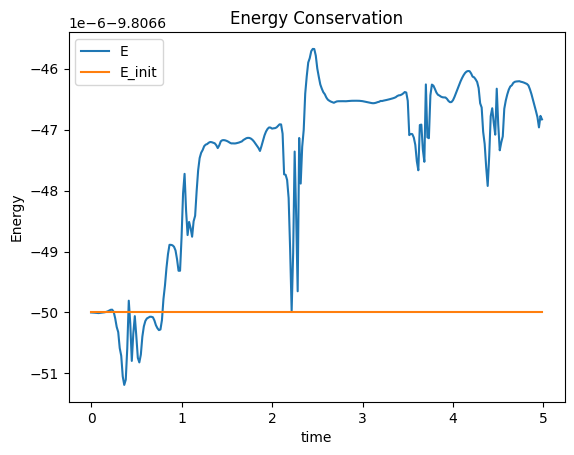

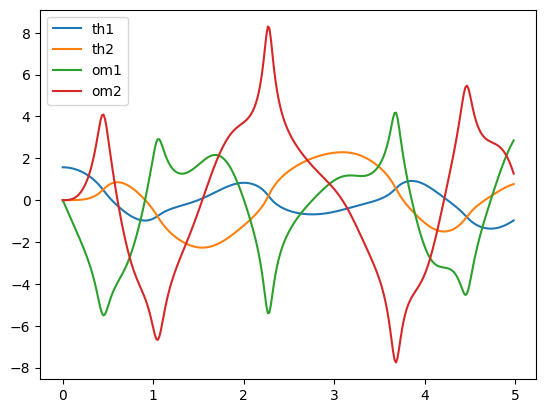

In [266]:
th1_0 = np.pi/2
th2_0 = 0
om1_0 = 0
om2_0 = 0
t0 = 0
tf = 5
dt = 1/60
t, th1, th2, om1, om2 = get_data(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
E = energy(th1, th2, om1, om2)
E_init = E[0]
plt.plot(t, E, label='E')
plt.plot(t, np.ones(t.shape)*E_init, label='E_init')
plt.legend()
plt.title('Energy Conservation')
plt.xlabel('time')
plt.ylabel('Energy')
plt.show()
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.legend()
plt.show()

In [ ]:
ani = animate(t, dt, th1, th2)
HTML(ani.to_html5_video())

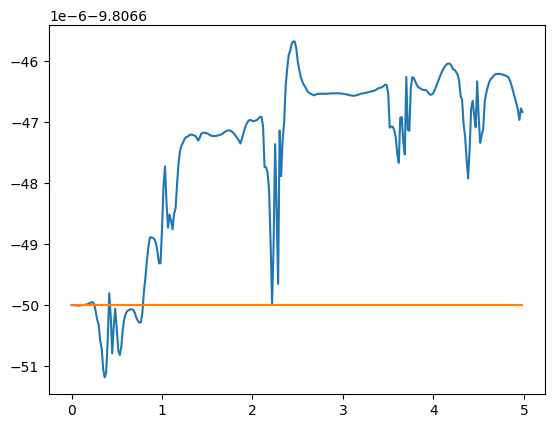

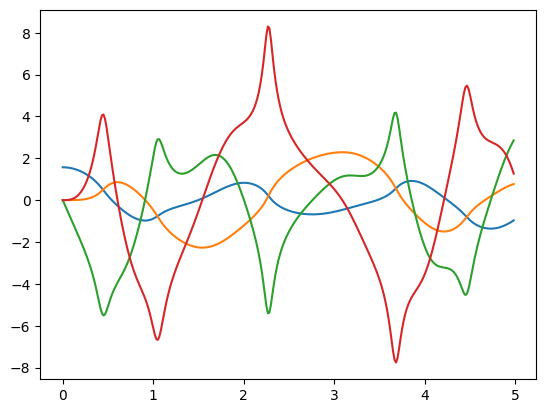

In [265]:
batch_size = 1
th1_0 = np.pi/2 * np.ones((batch_size))
th2_0 = 0 * np.ones((batch_size))
om1_0 = 0 * np.ones((batch_size))
om2_0 = 0 * np.ones((batch_size))
t0 = 0 * np.ones((batch_size))
tf = 5 * np.ones((batch_size))
dt = 1/60 * np.ones((batch_size))
t, th1, th2, om1, om2 = get_data_batch(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
E = energy(th1, th2, om1, om2)
E_init = E[0]
plt.plot(t, E, label='E')
plt.plot(t, np.ones((t.size,1))*np.reshape(E_init, (1,-1)), label='E_init')
plt.show()
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.show()

(300, 10)


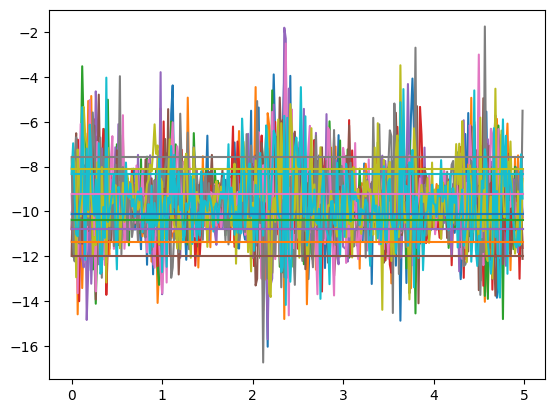

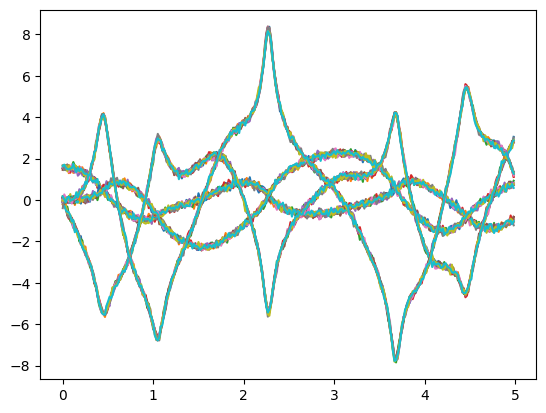

In [130]:
batch_size = 10
th1_0 = np.pi/2 * np.ones((batch_size))
th2_0 = 0 * np.ones((batch_size))
om1_0 = 0 * np.ones((batch_size))
om2_0 = 0 * np.ones((batch_size))
t0 = 0 * np.ones((batch_size))
tf = 5 * np.ones((batch_size))
dt = 1/60 * np.ones((batch_size))
noise = 0.1
t, th1, th2, om1, om2 = get_data_batch_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise)
E = energy(th1, th2, om1, om2)
E_init = E[0]
print(th1.shape)
plt.plot(t, E, label='E')
plt.plot(t, np.ones((t.size,1))*np.reshape(E_init, (1,-1)), label='E_init')
plt.show()
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.show()

In [ ]:
ani = animate_batch(t, dt, th1, th2)
HTML(ani.to_html5_video())

In [233]:
def predict_linear(dt, dt_int, th1, th2, om1, om2):
    """
    Prediction step function for use in kalman filter.
    Uses instantaneous linearized dynamics.
    dt_int unused for compatibility with predict_nonlinear.
    """
    y = np.array([th1, th2, om1, om2])
    [th1_pred, th2_pred, om1_pred, om2_pred] = y + dt * dydt(y, t=0)
    return th1_pred, th2_pred, om1_pred, om2_pred

def predict_nonlinear(dt, dt_int, th1, th2, om1, om2):
    """
    Prediction step function for use in kalman filter.
    Uses integration of nonlinear dynamics.
    """
    if len(th1.shape) == 1:
        t, th1_pred, th2_pred, om1_pred, om2_pred = get_data(th1, th2, om1, om2, 0, dt+dt_int/100, dt_int)
        return th1_pred[-1], th2_pred[-1], om1_pred[-1], om2_pred[-1]
    else:
        t, th1_pred, th2_pred, om1_pred, om2_pred = get_data_batch(th1.reshape(-1), th2.reshape(-1), 
                                                                   om1.reshape(-1), om2.reshape(-1), np.zeros_like(dt), dt+dt_int/100, dt_int)
        return th1_pred[-1,:], th2_pred[-1,:], om1_pred[-1,:], om2_pred[-1,:]

def kalman_filter(t, th1, th2, om1, om2, Q, R, predict=predict_linear, int_factor=60):
    """
    Emulates kalman filter for double pendulum system
    Uses linearized dynamics for prediction step
    Input:
    - t: (N,) ndarray
    - th1, th2: (N,) ndarray
    - om1, om2: (N,) ndarray
    - Q: (4,) ndarray (process noise covariance)
    - R: (4,) ndarray (measurement noise covariance)
    - predict: function (default: predict_linear)
    - int_factor: int (default: 60)
    Output:
    - th1_kf, th2_kf: (N,) ndarray
    """
    if len(th1.shape) != 1:
        raise ValueError('th1 and th2 must be (N,) ndarray')
    if len(th2.shape) != 1:
        raise ValueError('th1 and th2 must be (N,) ndarray')
    if len(om1.shape) != 1:
        raise ValueError('om1 and om2 must be (N,) ndarray')
    if len(om2.shape) != 1:
        raise ValueError('om1 and om2 must be (N,) ndarray')
    
    # Initialize
    P = np.zeros((4,4)) # Initial state covariance
    th1_kf = np.zeros(th1.shape)
    th2_kf = np.zeros(th2.shape)
    om1_kf = np.zeros(om1.shape)
    om2_kf = np.zeros(om2.shape)
    th1_kf[0] = th1[0]
    th2_kf[0] = th2[0]
    om1_kf[0] = om1[0]
    om2_kf[0] = om2[0]
    for i in range(1, t.size):
        # Prediction step
        dt = t[i] - t[i-1]
        dt_int = dt/int_factor
        th1_pred, th2_pred, om1_pred, om2_pred = predict(dt, dt_int, th1_kf[i-1], th2_kf[i-1], om1[i-1], om2[i-1])
        P_pred = P + Q
        # Update step
        K = P_pred @ np.linalg.inv(P_pred + R)
        y = np.array([th1[i], th2[i], om1[i], om2[i]])
        y_pred = np.array([th1_pred, th2_pred, om1_pred, om2_pred])
        th1_kf[i], th2_kf[i], om1_kf[i], om2_kf[i] = y_pred + K @ (y - y_pred)
        P = (np.eye(4) - K) @ P_pred
        
    return th1_kf, th2_kf, om1_kf, om2_kf

def kalman_filter_batch(t, th1, th2, om1, om2, Q, R, predict=predict_linear, int_factor=60):
    """
    Emulates kalman filter for a batched double pendulum system
    Uses linearized dynamics for prediction step
    Input:
    - t: (N,) ndarray
    - th1, th2: (N,batch_size) ndarray
    - om1, om2: (N,batch_size) ndarray
    - Q: (4,) ndarray (process noise covariance)
    - R: (4,) ndarray (measurement noise covariance)
    - predict: function (default: predict_linear)
    - int_factor: int (default: 60)
    Output:
    - th1_kf, th2_kf: (N,batch_size) ndarray
    """
    if len(th1.shape) != 2:
        raise ValueError('th1 and th2 must be (N,batch_size) ndarray')
    if len(th2.shape) != 2:
        raise ValueError('th1 and th2 must be (N,batch_size) ndarray')
    if len(om1.shape) != 2:
        raise ValueError('om1 and om2 must be (N,batch_size) ndarray')
    if len(om2.shape) != 2:
        raise ValueError('om1 and om2 must be (N,batch_size) ndarray')
    
    # Initialize
    P = np.zeros((4,4)) # Initial state covariance
    th1_kf = np.zeros(th1.shape)
    th2_kf = np.zeros(th2.shape)
    om1_kf = np.zeros(om1.shape)
    om2_kf = np.zeros(om2.shape)
    th1_kf[0,:] = th1[0,:]
    th2_kf[0,:] = th2[0,:]
    om1_kf[0,:] = om1[0,:]
    om2_kf[0,:] = om2[0,:]
    for i in range(1, t.size):
        # Prediction step
        dt = (t[i] - t[i-1])*np.ones((th1.shape[1]))
        dt_int = dt/int_factor
        th1_pred, th2_pred, om1_pred, om2_pred = predict(dt, dt_int, th1_kf[i-1:i,:], th2_kf[i-1:i,:], om1[i-1:i,:], om2[i-1:i,:]) # Preserve 2D shape in splicing
        P_pred = P + Q
        # Update step
        K = P_pred @ np.linalg.inv(P_pred + R)
        y = np.vstack([th1[i:i+1,:], th2[i:i+1,:], om1[i:i+1,:], om2[i:i+1,:]])
        y_pred = np.vstack([th1_pred, th2_pred, om1_pred, om2_pred])
        th1_kf[i,:], th2_kf[i,:], om1_kf[i,:], om2_kf[i,:] = y_pred + K @ (y - y_pred)
        P = (np.eye(4) - K) @ P_pred

    return th1_kf, th2_kf, om1_kf, om2_kf

(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 2)
(300, 2)
(2,)
(2,)
(300, 2)
(300, 2)
(300, 

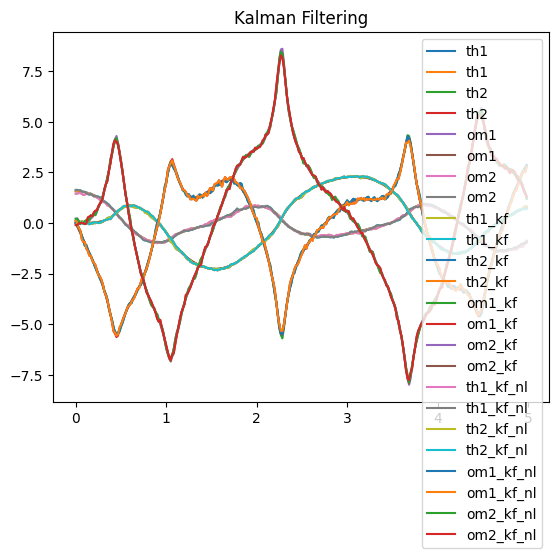

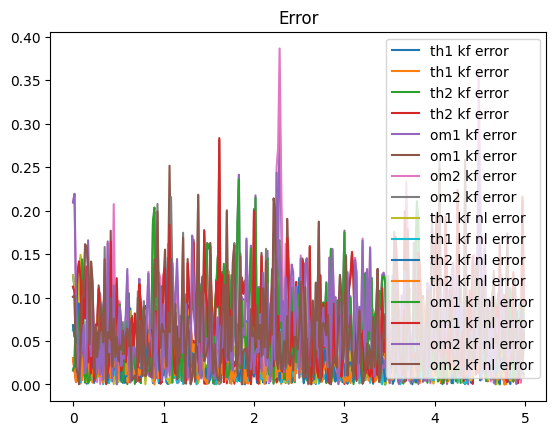

Th kf error:  0.049754832011721116
Om kf error:  0.102561856948186
Th kf nl error:  0.049276418772747486
Om kf nl error:  0.09863634753116078


In [228]:
batch_size = 2
th1_0 = np.pi/2 * np.ones((batch_size))
th2_0 = 0 * np.ones((batch_size))
om1_0 = 0 * np.ones((batch_size))
om2_0 = 0 * np.ones((batch_size))
t0 = 0 * np.ones((batch_size))
tf = 5 * np.ones((batch_size))
dt = 1/60 * np.ones((batch_size))
noise = 0.1
t, th1, th2, om1, om2 = get_data_batch(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
t, th1_noisy, th2_noisy, om1_noisy, om2_noisy = get_data_batch_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise)
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')

Q = np.diag([0.01, 0.01, 0.01, 0.01])
R = np.eye(4)*noise
th1_kf, th2_kf, om1_kf, om2_kf = kalman_filter_batch(t, th1_noisy, th2_noisy, om1_noisy, om2_noisy, Q, R)
plt.plot(t, th1_kf, label='th1_kf')
plt.plot(t, th2_kf, label='th2_kf')
plt.plot(t, om1_kf, label='om1_kf')
plt.plot(t, om2_kf, label='om2_kf')

th1_kf_nl, th2_kf_nl, om1_kf_nl, om2_kf_nl = kalman_filter_batch(t, th1_noisy, th2_noisy, om1_noisy, om2_noisy, Q, R, predict=predict_nonlinear)
plt.plot(t, th1_kf_nl, label='th1_kf_nl')
plt.plot(t, th2_kf_nl, label='th2_kf_nl')
plt.plot(t, om1_kf_nl, label='om1_kf_nl')
plt.plot(t, om2_kf_nl, label='om2_kf_nl')
plt.title('Kalman Filtering')
plt.legend()
plt.show()

plt.plot(t, abs(th1 - th1_kf), label='th1 kf error')
plt.plot(t, abs(th2 - th2_kf), label='th2 kf error')
plt.plot(t, abs(om1 - om1_kf), label='om1 kf error')
plt.plot(t, abs(om2 - om2_kf), label='om2 kf error')
plt.plot(t, abs(th1 - th1_kf_nl), label='th1 kf nl error')
plt.plot(t, abs(th2 - th2_kf_nl), label='th2 kf nl error')
plt.plot(t, abs(om1 - om1_kf_nl), label='om1 kf nl error')
plt.plot(t, abs(om2 - om2_kf_nl), label='om2 kf nl error')
plt.title('Error')
plt.legend()
plt.show()

th_kf_err = np.mean(np.sqrt((th1 - th1_kf)**2 + (th2 - th2_kf)**2))
om_kf_err = np.mean(np.sqrt((om1 - om1_kf)**2 + (om2 - om2_kf)**2))
th_kf_nl_err = np.mean(np.sqrt((th1 - th1_kf_nl)**2 + (th2 - th2_kf_nl)**2))
om_kf_nl_err = np.mean(np.sqrt((om1 - om1_kf_nl)**2 + (om2 - om2_kf_nl)**2))
print("Th kf error: ", th_kf_err)
print("Om kf error: ", om_kf_err)
print("Th kf nl error: ", th_kf_nl_err)
print("Om kf nl error: ", om_kf_nl_err)

In [ ]:
th1_ani = np.hstack((th1, th1_noisy))
th2_ani = np.hstack((th2, th2_noisy))
ani_noisy = animate_batch(t, dt, th1_ani, th2_ani, title='Noisy Data')
HTML(ani_noisy.to_html5_video())

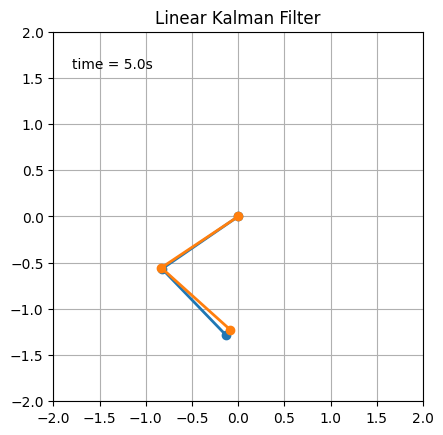

In [64]:
th1_ani = np.hstack((th1, th1_kf))
th2_ani = np.hstack((th2, th2_kf))
ani_kf = animate_batch(t, dt, th1_ani, th2_ani, title='Linear Kalman Filter')
HTML(ani_kf.to_html5_video())

In [ ]:
th1_ani = np.hstack((th1, th1_kf_nl))
th2_ani = np.hstack((th2, th2_kf_nl))
ani_kf_nl = animate_batch(t, dt, th1_ani, th2_ani, title='Nonlinear Kalman Filter')
HTML(ani_kf_nl.to_html5_video())

In [234]:
# Define the objective function for the least squares problem
def objective(t, x_est, y_meas, alpha, beta, gamma, delta, prediction, int_factor=100):
    """
    Energy variance regulation
    Input:
    - t: (N,) ndarray
    - x_est: (4,N) ndarray
    - y_meas: (4,N) ndarray
    - alpha: scalar (hyperparameter)
    - beta: scalar (hyperparameter)
    - gamma: scalar (hyperparameter)
    - delta: scalar (hyperparameter)
    """
    # Propagate dynamics for each time step
    dt = t[1:] - t[:-1]
    dt_int = dt/int_factor
    th1_pred, th2_pred, om1_pred, om2_pred = prediction(dt, dt_int, x_est[0:1,:-1], x_est[1:2,:-1], x_est[2:3,:-1], x_est[3:4,:-1])
    x_pred = np.vstack((th1_pred, th2_pred, om1_pred, om2_pred))

    # Dynamics residual (N-1,)
    r1 = np.sum((x_est[:,1:] - x_pred)**2, axis=0)

    # Measurement residual (N,)
    r2 = np.sum((y_meas - x_est)**2, axis=0)

    # Energy variance residual -- regularization (N,)
    E = energy(x_est[0,:], x_est[1,:], x_est[2,:], x_est[3,:])
    r3 = (E - np.mean(E))**2

    # Smoothness residual -- regularization (N-1,)
    r4 = np.sum((x_est[:, 1:] - x_est[:, :-1])**2, axis=0)

    r = np.hstack((alpha * r1, beta * r2, gamma * r3, delta * r4))
    return r

def gauss_newton_iteration(t, x_est, y_meas, alpha, beta, gamma, delta, eta, prediction=predict_linear, num_samples=60):
    """
    Input:
    - t: (N,) ndarray
    - x_est: (4,N) ndarray
    - y_meas: (4,N) ndarray
    - alpha: scalar (hyperparameter)
    - beta: scalar (hyperparameter)
    - gamma: scalar (hyperparameter)
    - delta: scalar (hyperparameter)
    - eta: scalar (learning rate)
    - prediction: function handle
    - num_samples: scalar (number of samples to use for stochastic gradient descent)
    """
    # Initialize Jacobian matrices
    M = x_est.shape[0]
    N = x_est.shape[1]
    J1 = np.zeros((N-1, M*N)) # (N-1,4*N)
    J2 = np.zeros((N, M*N)) # (N,4*N)
    J3 = np.copy(J2) # (N,4*N)
    J4 = np.copy(J1) # (N-1,4*N)
    J = np.vstack((J1, J2, J3, J4)) # (4*N-2,4*N)

    # Stochastic selection
    idx = np.empty((num_samples, 2), dtype=int)
    idx[:, 0] = np.random.randint(0, M, size=num_samples)
    idx[:, 1] = np.random.randint(0, N, size=num_samples)

    # Evaluate the Jacobian matrices
    for [i, j] in idx:
        perturb = np.zeros_like(x_est)
        eps = 1e-2 # Small perturbation for numerical differentiation
        perturb[i,j] = eps 
        residuals = (objective(t, x_est + perturb, y_meas, alpha, beta, gamma, delta, prediction) - 
                objective(t, x_est - perturb, y_meas, alpha, beta, gamma, delta, prediction)) / (2 * eps)
        J[:, i * N + j] = residuals

    # Evaluate the objective function
    residuals = objective(t, x_est, y_meas, alpha, beta, gamma, delta, prediction)

    # Compute the update step using the Gauss-Newton update equation
    x_update = np.linalg.lstsq(J, residuals, rcond=None)[0]

    # Update the state estimate
    x_est_updated = x_est - eta * x_update.reshape(x_est.shape)

    return x_est_updated

In [ ]:
# Generate noisy trajectory
th1_0 = np.pi/2
th2_0 = 0
om1_0 = 0
om2_0 = 0
noise = 0.5
t0 = 0
tf = 1
dt = 1/60
t, th1, th2, om1, om2 = get_data(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
t, th1_noisy, th2_noisy, om1_noisy, om2_noisy = get_data_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise)
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.plot(t, th1_noisy, label='th1 noisy')
plt.plot(t, th2_noisy, label='th2 noisy')
plt.plot(t, om1_noisy, label='om1 noisy')
plt.plot(t, om2_noisy, label='om2 noisy')
plt.legend()
plt.show()

# Initialize
y_meas = np.vstack((th1_noisy, th2_noisy, om1_noisy, om2_noisy))
x_est = y_meas
alpha = 1
beta = 1
gamma = 0.0001
delta = 10
eta = .001
pred_func = predict_linear
num_samples = 60
max_iterations = 5000
tolerance = 5e-3
obj_val_best = np.inf
x_truth = np.vstack((th1, th2, om1, om2))
best = np.linalg.norm(objective(t, x_truth, y_meas, alpha, beta, gamma, delta, pred_func))
print('Optimal solution objective value: ', best)

# Run Gauss-Newton iterations
for iteration in range(max_iterations):
    x_est_prior = x_est
    x_est = gauss_newton_iteration(t, x_est, y_meas, alpha, beta, gamma, delta, eta, prediction=pred_func, num_samples=num_samples)
    obj = objective(t, x_est, y_meas, alpha, beta, gamma, delta, pred_func)
    obj_val = np.linalg.norm(obj)
    opt_gap = np.linalg.norm(x_est - x_est_prior)
    if obj_val < obj_val_best:
        obj_val_best = obj_val
        x_est_best = x_est
        opt_gap_best = opt_gap
    if iteration % (max_iterations//10) == 0:
        print(iteration, ', objective = ', obj_val, ': optimality gap = ', opt_gap)
        plt.plot(t, th1, label='th1')
        plt.plot(t, th2, label='th2')
        plt.plot(t, om1, label='om1')
        plt.plot(t, om2, label='om2')
        plt.plot(t, x_est[0,:], label='th1_gn')
        plt.plot(t, x_est[1,:], label='th2_gn')
        plt.plot(t, x_est[2,:], label='om1_gn')
        plt.plot(t, x_est[3,:], label='om2_gn')
        plt.legend()
        plt.show()
    if opt_gap < tolerance:
        break

print("Terminated after ", iteration, " iterations")
print("Best objective value: ", obj_val_best)
print("Distance: ", loss(x_est_best, x_truth))
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.plot(t, x_est_best[0,:], label='th1_gn')
plt.plot(t, x_est_best[1,:], label='th2_gn')
plt.plot(t, x_est_best[2,:], label='om1_gn')
plt.plot(t, x_est_best[3,:], label='om2_gn')
plt.legend()
plt.show()

gamma =  0.0001
Trial  0
0 , objective =  19.98253917245753 : optimality gap =  0.013543530888146577
500 , objective =  15.089974735623402 : optimality gap =  0.015922308395082792
1000 , objective =  12.6814412797229 : optimality gap =  0.029800576109535813
1500 , objective =  11.659979529242145 : optimality gap =  0.017594827003690493
2000 , objective =  13.873401418796039 : optimality gap =  0.029173925313495185
2500 , objective =  11.572608492738729 : optimality gap =  0.03130585531030583
3000 , objective =  10.582413535117034 : optimality gap =  0.011055273489780972
3500 , objective =  11.002317680919957 : optimality gap =  0.019460381629382364
4000 , objective =  10.077840270942179 : optimality gap =  0.06852216940531702
4500 , objective =  9.869554605097354 : optimality gap =  0.01631216841436869
Trial  1
0 , objective =  20.047642654231723 : optimality gap =  0.02481790730298357
500 , objective =  15.125220523610372 : optimality gap =  0.01938828013696797
1000 , objective =  12.

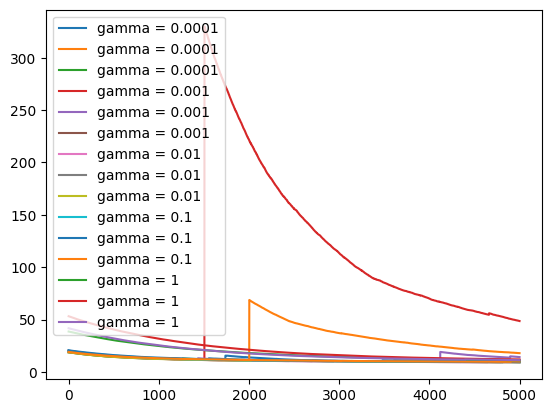

In [239]:
# Generate noisy trajectories
batch_size = 3
th1_0 = np.pi/2 * np.ones(batch_size)
th2_0 = 0 * np.ones(batch_size)
om1_0 = 0 * np.ones(batch_size)
om2_0 = 0 * np.ones(batch_size)
t0 = 0 * np.ones(batch_size)
tf = 1 * np.ones(batch_size)
dt = 1/60 * np.ones(batch_size)
noise = 0.1
t, th1, th2, om1, om2 = get_data(th1_0[0], th2_0[0], om1_0[0], om2_0[0], t0[0], tf[0], dt[0])
t, th1_noisy, th2_noisy, om1_noisy, om2_noisy = get_data_batch_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise)

# Hyperparameter tuning results
eta = 0.001 ## BEST

obj_history_params = []
for gamma in [0.0001, 0.001, 0.01, 0.1, 1]:
    print('gamma = ', gamma)

    obj_history_trials = []
    for trial in range(batch_size):
        print('Trial ', trial)
        
        # Initialize
        y_meas = np.vstack((th1_noisy[:,trial], th2_noisy[:,trial], om1_noisy[:,trial], om2_noisy[:,trial]))
        x_est = y_meas
        alpha = 1
        beta = 1
        ## gamma = 0.0001
        delta = 10
        pred_func = predict_linear
        num_samples = 60
        max_iterations = 5000
        tolerance = 5e-3
        obj_val_best = np.inf
        
        # Run Gauss-Newton iterations
        obj_history = []
        for iteration in range(max_iterations):
            x_est_prior = x_est
            x_est = gauss_newton_iteration(t, x_est, y_meas, alpha, beta, gamma, delta, eta, prediction=pred_func, num_samples=num_samples)
            obj = objective(t, x_est, y_meas, alpha, beta, gamma, delta, pred_func)
            obj_history.append(np.linalg.norm(obj))
            obj_val = np.linalg.norm(obj)
            opt_gap = np.linalg.norm(x_est - x_est_prior)
            if obj_val < obj_val_best:
                obj_val_best = obj_val
                x_est_best = x_est
                opt_gap_best = opt_gap
            if iteration % (max_iterations//10) == 0:
                print(iteration, ', objective = ', obj_val, ': optimality gap = ', opt_gap)
        plt.plot(range(max_iterations), obj_history, label='gamma = ' + str(gamma))
        obj_history_trials.append(obj_history)
    obj_history_params.append(obj_history_trials)

plt.legend()
plt.show()

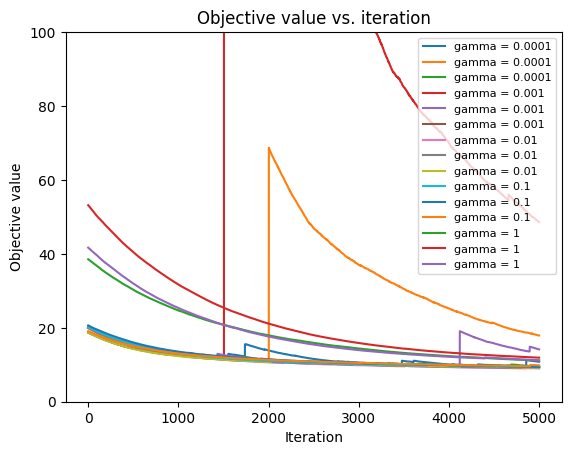

In [251]:
for i in range(len(obj_history_params)):
    for j in range(len(obj_history_params[i])):
        plt.plot(range(max_iterations), obj_history_params[i][j], label='gamma = ' + str([0.0001, 0.001, 0.01, 0.1, 1][i]))
plt.title('Objective value vs. iteration')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.ylim([0, 100])
plt.legend(fontsize=8, loc='upper right')
plt.show()

delta =  1
Trial  0
0 , objective =  58.244774127889805 : optimality gap =  0.007443109834222318
500 , objective =  41.6846665961131 : optimality gap =  0.043938809642589075
1000 , objective =  30.223608057526658 : optimality gap =  0.007449585926482995
1500 , objective =  22.20585687442822 : optimality gap =  0.001727055402836787
2000 , objective =  16.32698205373178 : optimality gap =  0.0019707953708983333
2500 , objective =  12.294547424035901 : optimality gap =  0.0019885962223153276
3000 , objective =  9.27762630969727 : optimality gap =  0.0021628554529429995
3500 , objective =  7.068241210210687 : optimality gap =  0.0030509416388224634
4000 , objective =  5.515280776107493 : optimality gap =  0.001353834988854027
4500 , objective =  4.386781486497098 : optimality gap =  0.0017591839864114299
Trial  1
0 , objective =  39.175091274074035 : optimality gap =  0.00694629523388163
500 , objective =  28.031638628167812 : optimality gap =  0.006397275945431219
1000 , objective =  20.5

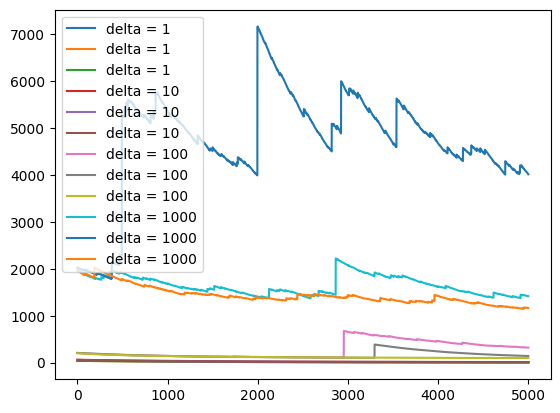

In [252]:
# Generate noisy trajectories
batch_size = 3
th1_0 = np.pi/2 * np.ones(batch_size)
th2_0 = 0 * np.ones(batch_size)
om1_0 = 0 * np.ones(batch_size)
om2_0 = 0 * np.ones(batch_size)
t0 = 0 * np.ones(batch_size)
tf = 1 * np.ones(batch_size)
dt = 1/60 * np.ones(batch_size)
noise = 0.1
t, th1, th2, om1, om2 = get_data(th1_0[0], th2_0[0], om1_0[0], om2_0[0], t0[0], tf[0], dt[0])
t, th1_noisy, th2_noisy, om1_noisy, om2_noisy = get_data_batch_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise)

# Hyperparameter tuning results
eta = 0.001 ## BEST
gamma = 1 ## BEST

obj_history_params = []
for delta in [1, 10, 100, 1000]:
    print('delta = ', delta)

    obj_history_trials = []
    for trial in range(batch_size):
        print('Trial ', trial)
        
        # Initialize
        y_meas = np.vstack((th1_noisy[:,trial], th2_noisy[:,trial], om1_noisy[:,trial], om2_noisy[:,trial]))
        x_est = y_meas
        alpha = 1
        beta = 1
        ## delta = 10
        pred_func = predict_linear
        num_samples = 60
        max_iterations = 5000
        tolerance = 5e-3
        obj_val_best = np.inf
        
        # Run Gauss-Newton iterations
        obj_history = []
        for iteration in range(max_iterations):
            x_est_prior = x_est
            x_est = gauss_newton_iteration(t, x_est, y_meas, alpha, beta, gamma, delta, eta, prediction=pred_func, num_samples=num_samples)
            obj = objective(t, x_est, y_meas, alpha, beta, gamma, delta, pred_func)
            obj_history.append(np.linalg.norm(obj))
            obj_val = np.linalg.norm(obj)
            opt_gap = np.linalg.norm(x_est - x_est_prior)
            if obj_val < obj_val_best:
                obj_val_best = obj_val
                x_est_best = x_est
                opt_gap_best = opt_gap
            if iteration % (max_iterations//10) == 0:
                print(iteration, ', objective = ', obj_val, ': optimality gap = ', opt_gap)
        plt.plot(range(max_iterations), obj_history, label='delta = ' + str(delta))
        obj_history_trials.append(obj_history)
    obj_history_params.append(obj_history_trials)

plt.legend()
plt.show()

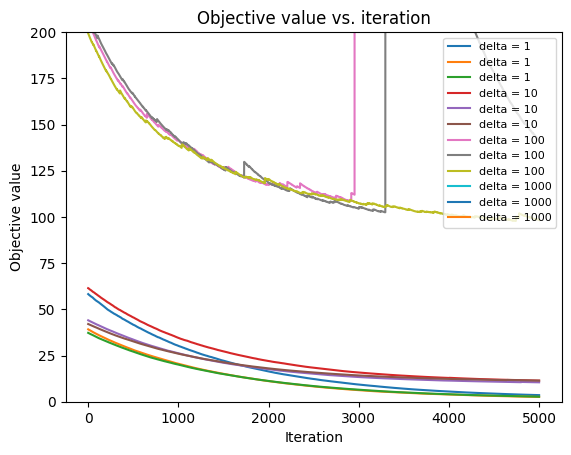

In [260]:
for i in range(len(obj_history_params)):
    for j in range(len(obj_history_params[i])):
        plt.plot(range(max_iterations), obj_history_params[i][j], label='delta = ' + str([1, 10, 100, 1000][i]))
plt.title('Objective value vs. iteration')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.ylim([0, 200])
plt.legend(fontsize=8, loc='upper right')
plt.show()

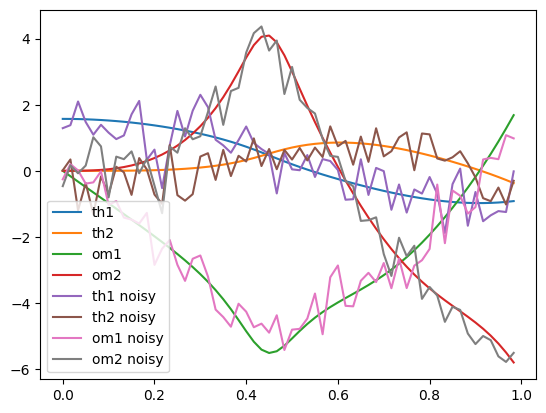

Optimal solution objective value:  12.006237726887447
0 , objective =  849.1858158073467 : optimality gap =  0.2312816834282788


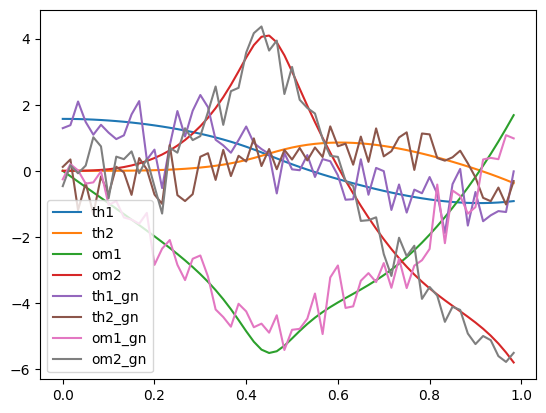

500 , objective =  48.104100933757394 : optimality gap =  0.04893305820158109


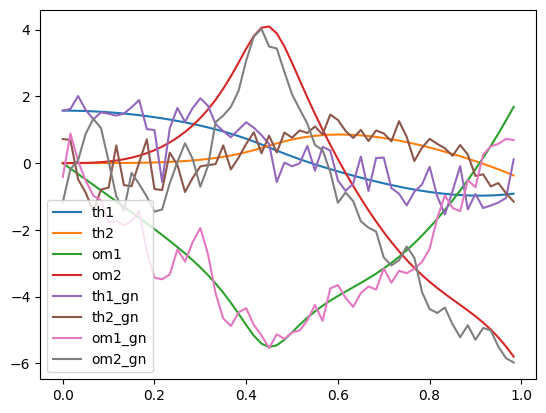

1000 , objective =  14.599882646128828 : optimality gap =  0.018996472402907177


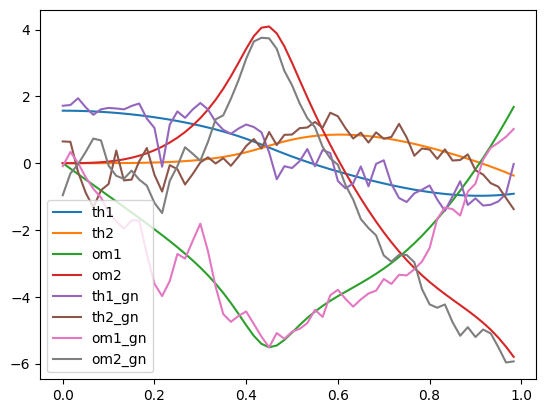

1500 , objective =  10.988113417226899 : optimality gap =  0.01583180526620782


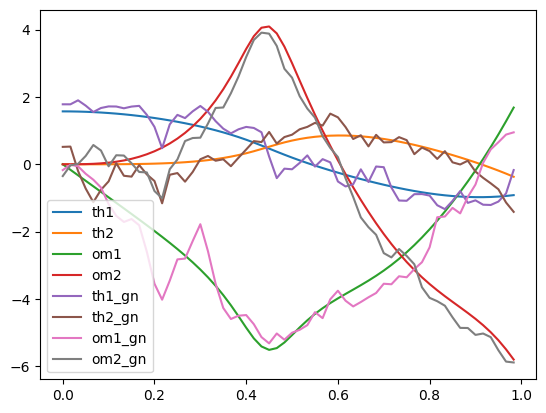

2000 , objective =  8.885434830695079 : optimality gap =  0.01051081401181739


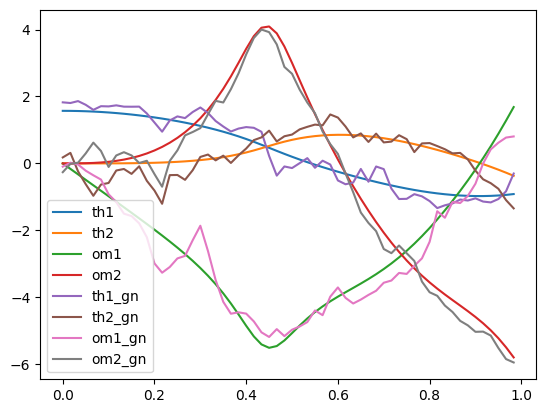

2500 , objective =  8.154195760218547 : optimality gap =  0.012062985348062858


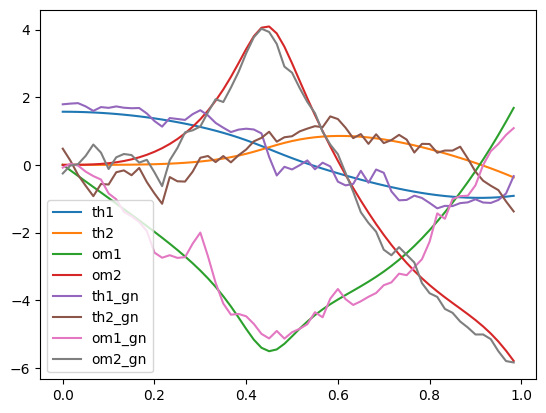

3000 , objective =  7.761675551336932 : optimality gap =  0.004221597718179485


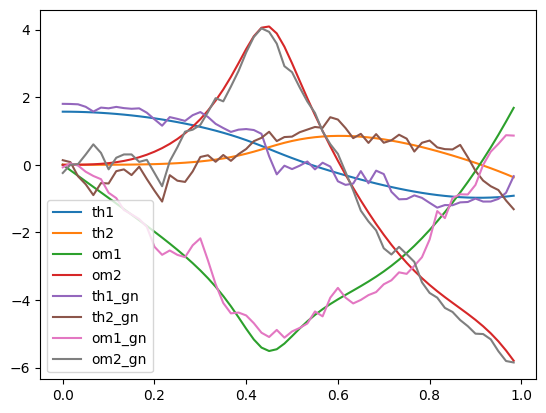

3500 , objective =  7.532526518145164 : optimality gap =  0.0029365965400919764


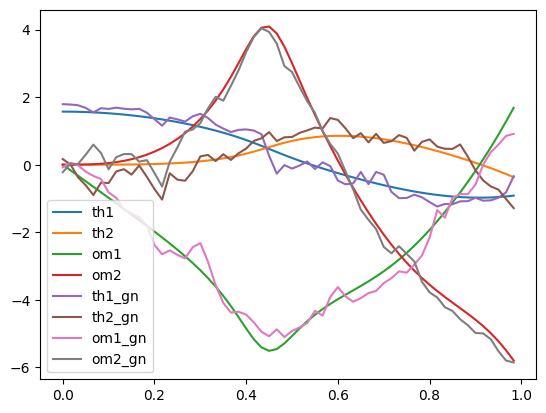

4000 , objective =  7.541033798395037 : optimality gap =  0.00391453210602197


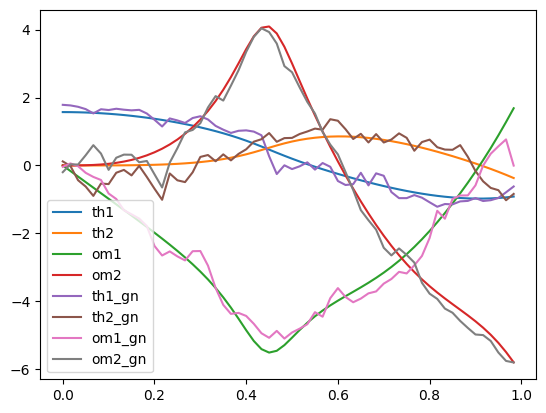

4500 , objective =  7.202002556590998 : optimality gap =  0.004417199747522847


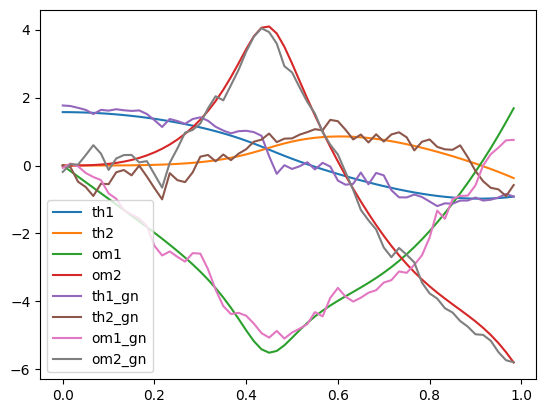

Terminated after  4999  iterations
Best objective value:  7.137652712145334
Distance:  20.688363626658436


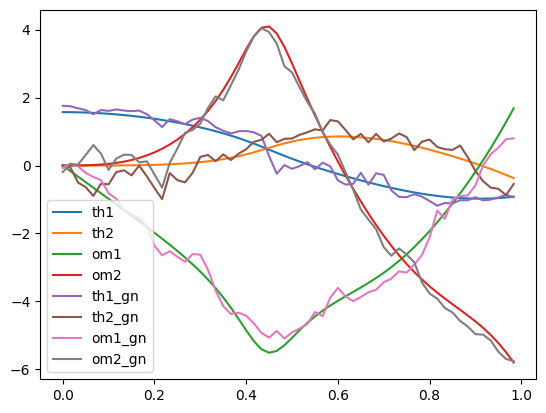

In [281]:
# Generate noisy trajectory
th1_0 = np.pi/2
th2_0 = 0
om1_0 = 0
om2_0 = 0
noise = 0.5
t0 = 0
tf = 1
dt = 1/60
t, th1, th2, om1, om2 = get_data(th1_0, th2_0, om1_0, om2_0, t0, tf, dt)
t, th1_noisy, th2_noisy, om1_noisy, om2_noisy = get_data_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise)
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.plot(t, th1_noisy, label='th1 noisy')
plt.plot(t, th2_noisy, label='th2 noisy')
plt.plot(t, om1_noisy, label='om1 noisy')
plt.plot(t, om2_noisy, label='om2 noisy')
plt.legend()
plt.show()

# Initialize
y_meas = np.vstack((th1_noisy, th2_noisy, om1_noisy, om2_noisy))
x_est = y_meas
alpha = 1
beta = 1
gamma = 1 ## BEST
delta = 1 ## BEST
eta = .01 # .001 ## BEST
pred_func = predict_linear
num_samples = 60
max_iterations = 5000
tolerance = 1e-8
obj_val_best = np.inf
x_truth = np.vstack((th1, th2, om1, om2))
best = np.linalg.norm(objective(t, x_truth, y_meas, alpha, beta, gamma, delta, pred_func))
print('Optimal solution objective value: ', best)

# Run Gauss-Newton iterations
for iteration in range(max_iterations):
    x_est_prior = x_est
    x_est = gauss_newton_iteration(t, x_est, y_meas, alpha, beta, gamma, delta, eta, prediction=pred_func, num_samples=num_samples)
    obj = objective(t, x_est, y_meas, alpha, beta, gamma, delta, pred_func)
    obj_val = np.linalg.norm(obj)
    opt_gap = np.linalg.norm(x_est - x_est_prior)
    if obj_val < obj_val_best:
        obj_val_best = obj_val
        x_est_best = x_est
        opt_gap_best = opt_gap
    if iteration % (max_iterations//10) == 0:
        print(iteration, ', objective = ', obj_val, ': optimality gap = ', opt_gap)
        plt.plot(t, th1, label='th1')
        plt.plot(t, th2, label='th2')
        plt.plot(t, om1, label='om1')
        plt.plot(t, om2, label='om2')
        plt.plot(t, x_est[0,:], label='th1_gn')
        plt.plot(t, x_est[1,:], label='th2_gn')
        plt.plot(t, x_est[2,:], label='om1_gn')
        plt.plot(t, x_est[3,:], label='om2_gn')
        plt.legend()
        plt.show()
    if opt_gap < tolerance:
        break

print("Terminated after ", iteration, " iterations")
print("Best objective value: ", obj_val_best)
print("Distance: ", loss(x_est_best, x_truth))
plt.plot(t, th1, label='th1')
plt.plot(t, th2, label='th2')
plt.plot(t, om1, label='om1')
plt.plot(t, om2, label='om2')
plt.plot(t, x_est_best[0,:], label='th1_gn')
plt.plot(t, x_est_best[1,:], label='th2_gn')
plt.plot(t, x_est_best[2,:], label='om1_gn')
plt.plot(t, x_est_best[3,:], label='om2_gn')
plt.legend()
plt.show()

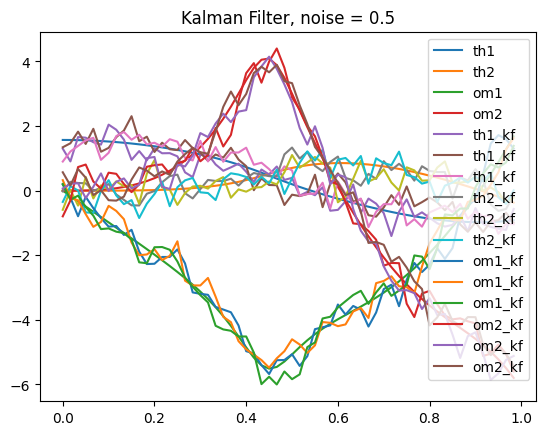

[28.49544418846138]
Trial  0
0 , objective =  728.2884624218567 : optimality gap =  0.49663923043885405
600 , objective =  35.06460045379495 : optimality gap =  0.023033365890337238
1200 , objective =  8.806671751332324 : optimality gap =  0.023544717602044858
1800 , objective =  6.581352153383516 : optimality gap =  0.006746945789972479
2400 , objective =  6.058276857943963 : optimality gap =  0.016438035714611728
3000 , objective =  5.775054041274604 : optimality gap =  0.007052622922882048
3600 , objective =  5.606661869648164 : optimality gap =  0.004255606754955665
4200 , objective =  6.798962177879283 : optimality gap =  0.004288164267791894
4800 , objective =  6.186326023217739 : optimality gap =  0.0041871452253901455
5400 , objective =  5.952284514913498 : optimality gap =  0.007953633055231377
Trial  1
0 , objective =  744.8284942729287 : optimality gap =  0.5899191363522034
600 , objective =  28.80064197421248 : optimality gap =  0.02599396946750357
1200 , objective =  10.73

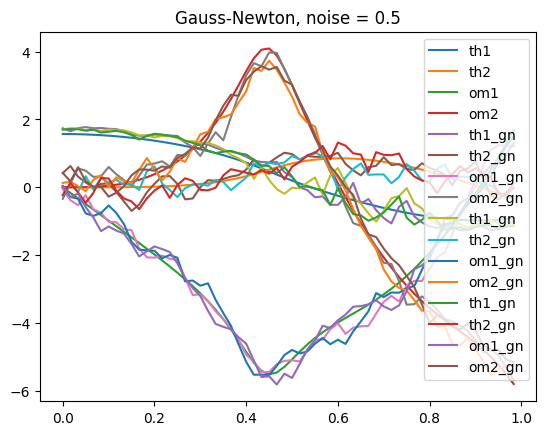

[16.879808138272868]


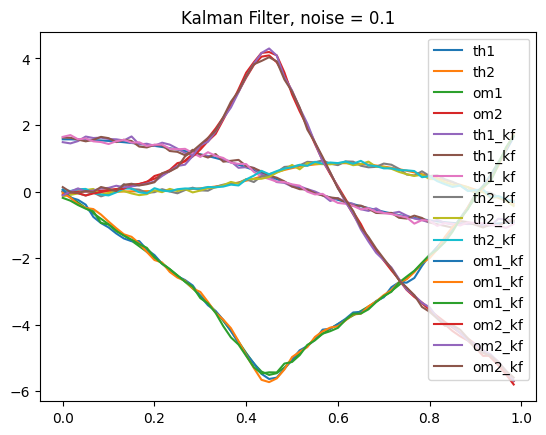

[28.49544418846138, 1.1811174825556232]
Trial  0
0 , objective =  51.16870154751888 : optimality gap =  0.09892347689439791
600 , objective =  2.96883055061539 : optimality gap =  0.01054732971907514
1200 , objective =  1.3729848837943528 : optimality gap =  0.013078352053590566
1800 , objective =  1.213946016061313 : optimality gap =  0.00236926137851714
2400 , objective =  1.19084007327846 : optimality gap =  0.0025320854925767458
3000 , objective =  1.1700157085132217 : optimality gap =  0.0012736132459480066
3600 , objective =  1.2685338186069803 : optimality gap =  0.00191153676870605
4200 , objective =  1.2055248552858533 : optimality gap =  0.0020639819120933838
4800 , objective =  1.1710523264996866 : optimality gap =  0.03501388779742309
5400 , objective =  1.165095360563432 : optimality gap =  0.04415509301521996
Trial  1
0 , objective =  56.34583217306966 : optimality gap =  0.3070500057156774
600 , objective =  2.784189045456255 : optimality gap =  0.022710450324898674
1200

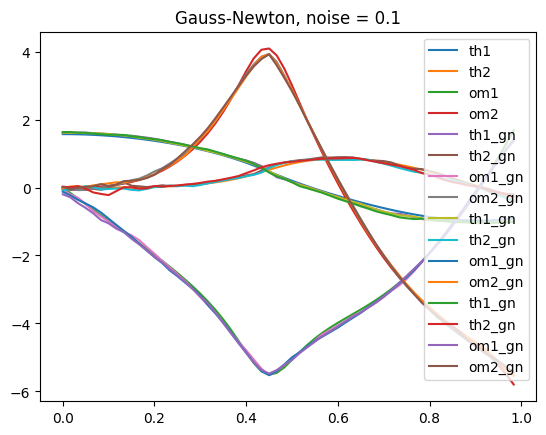

[16.879808138272868, 1.4558522547775936]


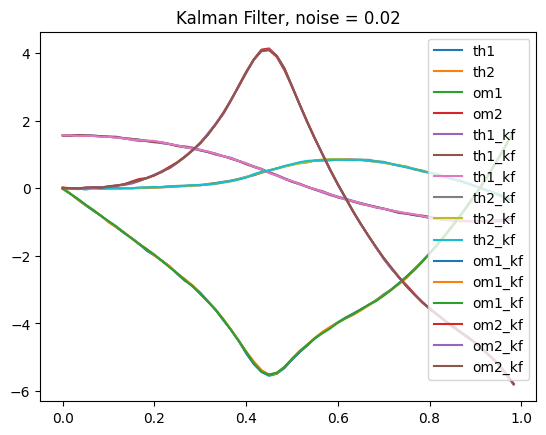

[28.49544418846138, 1.1811174825556232, 0.05242677664841383]
Trial  0
0 , objective =  2.170660477315593 : optimality gap =  0.03252003829104888
600 , objective =  1.1092530604254505 : optimality gap =  0.007210402463406593
1200 , objective =  1.0638045304860138 : optimality gap =  0.006633369159910926
1800 , objective =  1.1158681012240952 : optimality gap =  0.023216771271725535
2400 , objective =  1.0590498045493084 : optimality gap =  0.008896324672390253
3000 , objective =  1.051754166633354 : optimality gap =  0.030771295625284367
3600 , objective =  1.050887908820819 : optimality gap =  0.02331770057798005
4200 , objective =  1.061924117418036 : optimality gap =  0.013495704058295897
4800 , objective =  1.061606667765324 : optimality gap =  0.010318228640696004
5400 , objective =  1.0903264865568907 : optimality gap =  0.05699222013544983
Trial  1
0 , objective =  1.7694351394112473 : optimality gap =  0.029955178017272564
600 , objective =  1.1031392979929702 : optimality gap =

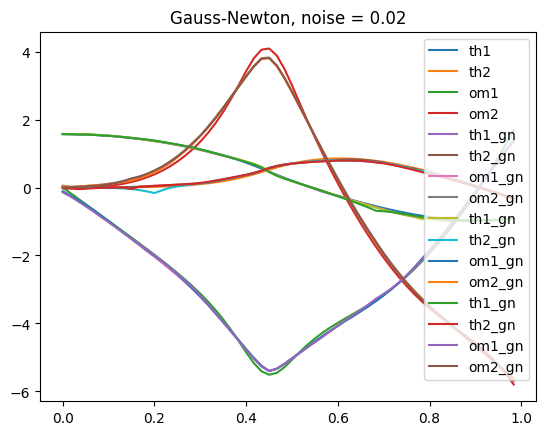

[16.879808138272868, 1.4558522547775936, 1.5141811141993238]


In [282]:
## COMPARE EKF AND GNA

accuracy_ekf = []
accuracy_gna = []
for noise in [0.5, 0.1, 0.02]:
    # Generate noisy trajectories
    batch_size = 3
    th1_0 = np.pi/2 * np.ones(batch_size)
    th2_0 = 0 * np.ones(batch_size)
    om1_0 = 0 * np.ones(batch_size)
    om2_0 = 0 * np.ones(batch_size)
    t0 = 0 * np.ones(batch_size)
    tf = 1 * np.ones(batch_size)
    dt = 1/60 * np.ones(batch_size)
    t, th1, th2, om1, om2 = get_data(th1_0[0], th2_0[0], om1_0[0], om2_0[0], t0[0], tf[0], dt[0])
    x_true = np.vstack((th1, th2, om1, om2))
    t, th1_noisy, th2_noisy, om1_noisy, om2_noisy = get_data_batch_noise(th1_0, th2_0, om1_0, om2_0, t0, tf, dt, noise)

    Q = np.eye(4)*noise
    R = np.eye(4)*noise
    th1_kf, th2_kf, om1_kf, om2_kf = kalman_filter_batch(t, th1_noisy, th2_noisy, om1_noisy, om2_noisy, Q, R)
    plt.plot(t, th1, label='th1')
    plt.plot(t, th2, label='th2')
    plt.plot(t, om1, label='om1')
    plt.plot(t, om2, label='om2')
    plt.plot(t, th1_kf, label='th1_kf')
    plt.plot(t, th2_kf, label='th2_kf')
    plt.plot(t, om1_kf, label='om1_kf')
    plt.plot(t, om2_kf, label='om2_kf')
    plt.title('Kalman Filter, noise = ' + str(noise))
    plt.legend()
    plt.show()
    accuracy_ekf.append( np.mean([loss(np.vstack((th1_kf[:,i], th2_kf[:,i], om1_kf[:,i], om2_kf[:,i])), x_true) for i in range(batch_size)]) )
    print(accuracy_ekf)

    plt.plot(t, th1, label='th1')
    plt.plot(t, th2, label='th2')
    plt.plot(t, om1, label='om1')
    plt.plot(t, om2, label='om2')
    accuracy_gna_trial = []
    for trial in range(batch_size):
        print('Trial ', trial)
        
        # Initialize
        y_meas = np.vstack((th1_noisy[:,trial], th2_noisy[:,trial], om1_noisy[:,trial], om2_noisy[:,trial]))
        x_est = y_meas
        alpha = 1
        beta = 1
        gamma = 1 ## BEST
        delta = 1 ## BEST
        eta = .01 ## Unsure what's best
        pred_func = predict_linear
        num_samples = 60
        max_iterations = 6000
        tolerance = 1e-8
        obj_val_best = np.inf
        
        # Run Gauss-Newton iterations
        for iteration in range(max_iterations):
            x_est_prior = x_est
            x_est = gauss_newton_iteration(t, x_est, y_meas, alpha, beta, gamma, delta, eta, prediction=pred_func, num_samples=num_samples)
            obj = objective(t, x_est, y_meas, alpha, beta, gamma, delta, pred_func)
            obj_history.append(np.linalg.norm(obj))
            obj_val = np.linalg.norm(obj)
            opt_gap = np.linalg.norm(x_est - x_est_prior)
            if obj_val < obj_val_best:
                obj_val_best = obj_val
                x_est_best = x_est
                opt_gap_best = opt_gap
            if iteration % (max_iterations//10) == 0:
                print(iteration, ', objective = ', obj_val, ': optimality gap = ', opt_gap)
        plt.plot(t, x_est_best[0,:], label='th1_gn')
        plt.plot(t, x_est_best[1,:], label='th2_gn')
        plt.plot(t, x_est_best[2,:], label='om1_gn')
        plt.plot(t, x_est_best[3,:], label='om2_gn')
        accuracy_gna_trial.append(loss(x_est_best, x_true))
    plt.title('Gauss-Newton, noise = ' + str(noise))
    plt.legend()
    plt.show()
    accuracy_gna.append(np.mean(accuracy_gna_trial))
    print(accuracy_gna)

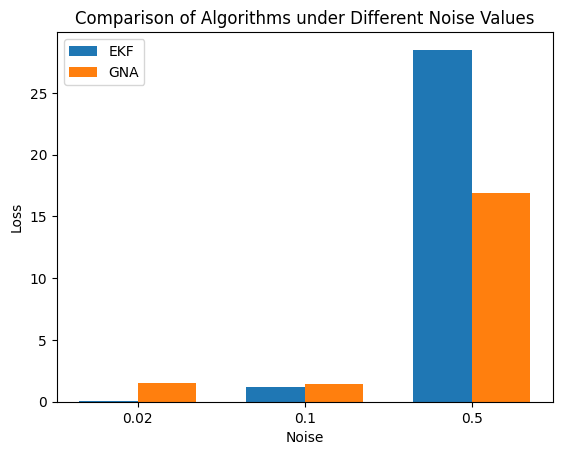

In [284]:
# Plotting the bar chart
noise_values = [0.02, 0.1, 0.5]
x = range(len(noise_values))
width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(x, accuracy_ekf[::-1], width, label='EKF')
bar2 = ax.bar([i + width for i in x], accuracy_gna[::-1], width, label='GNA')

# Adding labels, title, and customizing the axes
ax.set_xlabel('Noise')
ax.set_ylabel('Loss')
ax.set_title('Comparison of Algorithms under Different Noise Values')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(noise_values)
ax.legend()

# Displaying the bar chart
plt.show()